<a href="https://colab.research.google.com/github/SadeghMahmoudAbadi/Open-Source-LLM-on-Colab/blob/main/4-Airline-Assistant/Airline-Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kokoro>=0.9.2 soundfile
!apt-get -qq -y install espeak-ng > /dev/null 2>&1
!pip install ollama

In [2]:
from google.colab import userdata
from google.colab import drive
from ollama import Client
from diffusers import AutoPipelineForText2Image
from kokoro import KPipeline
from IPython.display import display, Audio
import soundfile as sf
import gradio as gr
import numpy as np
import sqlite3
import torch
import json
import gc

In [ ]:
drive.mount('/content/drive/')

In [4]:
ollama = Client(
    host="https://ollama.com",
    headers={'Authorization': 'Bearer ' + userdata.get("OLLAMA_API_KEY")}
)

MODEL = "gpt-oss:120b-cloud"
DB = "/content/drive/MyDrive/datasets/prices.db"

In [5]:
def set_ticket_price(city, price):
    print(f"DATABASE TOOL CALLED: Setting price for {city} to ${price}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('INSERT INTO prices (city, price) VALUES (?, ?) ON CONFLICT(city) DO UPDATE SET price = ?', (city.lower(), price, price))
        conn.commit()
    return f"Ticket price to {city} set to ${price}"

In [6]:
def get_ticket_price(city):
    print(f"DATABASE TOOL CALLED: Getting price for {city}", flush=True)
    with sqlite3.connect(DB) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT price FROM prices WHERE city = ?', (city.lower(),))
        result = cursor.fetchone()
        return f"Ticket price to {city} is ${result[0]}" if result else "No price data available for this city"

In [7]:
get_ticket_price("London")

DATABASE TOOL CALLED: Getting price for London


'Ticket price to London is $799.0'

In [8]:
set_price_function = {
    "name": "set_ticket_price",
    "description": "Set the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {
                "type": "string",
                "description": "The city that the user wants to set the ticket price for",
            },
            "price": {
                "type": "string",
                "description": "The price of the ticket in USD",
            },
        },
        "required": ["city", "price"],
        "additionalProperties": False
    }
}

In [9]:
get_price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city.",
    "parameters": {
        "type": "object",
        "properties": {
            "city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["city"],
        "additionalProperties": False
    }
}

In [10]:
tools = [
    {"type": "function", "function": get_price_function},
    {"type": "function", "function": set_price_function}
]

tool_registry = {"set_ticket_price": set_ticket_price, "get_ticket_price": get_ticket_price}

In [11]:
def handle_tool_calls(message):
    responses = []
    cities = []
    for tool_call in message or []:
        if tool_call.function.name not in tool_registry:
            print(f"NOT! {tool_call.function.name}")
            continue
        arguments = tool_call.function.arguments
        city = arguments.get('city')
        cities.append(city)
        result = tool_registry[tool_call.function.name](**arguments)
        responses.append({
            "role": "tool",
            "content": result
        })
    return responses, cities

In [12]:
system_prompt = """
You are a helpful assistant for an Airline called FlightAI.
Give short, courteous answers, no more than 1 sentence.
Always be accurate. If you don't know the answer, say so.
"""

In [13]:
def chat(history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_prompt}] + history
    response = ollama.chat(model=MODEL, messages=messages, tools=tools)
    cities = []
    image = None

    while "tool_calls" in response['message']:
        message = response['message']['tool_calls']
        responses, cities = handle_tool_calls(message)
        messages.extend(responses)
        response = ollama.chat(model=MODEL, messages=messages, tools=tools)

    reply = response['message']['content']
    history += [{"role":"assistant", "content":reply}]

    voice = talker(reply)

    if cities:
        image = poster(cities[0])

    return history, voice, image

In [14]:
def poster(city):
    pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
    pipe.to("cuda")
    prompt = f"An image representing a trip to {city}, showing unique aspects of {city}, in watercolor style."
    image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0.0).images[0]

    del pipe

    torch.cuda.empty_cache()
    gc.collect()

    return image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/4 [00:00<?, ?it/s]

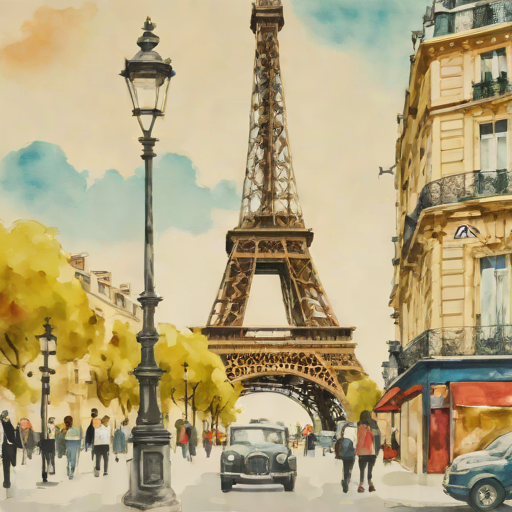

In [15]:
poster("paris")

In [16]:
def talker(text):
    pipe = KPipeline(lang_code='a')
    generator = pipe(text, voice='af_heart')
    audio_chunks = []

    for _, _, audio in generator:
        audio_chunks.append(audio)
    if not audio_chunks:
        return torch.empty(0)
    final_audio = torch.cat(audio_chunks, dim=0)
    final_audio_np = final_audio.cpu().numpy()

    return (24000, final_audio_np)

In [ ]:
def put_message_in_chatbot(message, history):
        return "", history + [{"role":"user", "content":message}]

with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500, interactive=False)
    with gr.Row():
        audio_output = gr.Audio(autoplay=True)
    with gr.Row():
        message = gr.Textbox(label="Chat with our AI Assistant:")

    message.submit(
        put_message_in_chatbot,
        inputs=[message, chatbot],
        outputs=[message, chatbot]
    ).then(
        chat,
        inputs=chatbot,
        outputs=[chatbot, audio_output, image_output]
    )

ui.launch(inbrowser=True, debug=True)